# 4.morphological features of reconstructed model

This notebook demonstrates the calculation of morphological features of 3D reconstructed model, including length, surface area, volume, cell density, cell distribution, etc.

## Packages

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.colors as mplc
import spateo as st

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/yao/.local/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spaghetti/network.py:36: Future

## Data source

In [2]:
adata = st.sample_data.drosophila(filename="E9-10h_cellbin_tdr_v2_CNS.h5ad")
adata

AnnData object with n_obs × n_vars = 4326 × 8484
    obs: 'area', 'slices', 'x', 'y', 'z', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'auto_anno', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage'
    uns: 'PCs', '__type', 'auto_anno_result', 'dendrogram_anno_cell_type', 'dendrogram_anno_germ_layer', 'dendrogram_anno_tissue', 'dendrogram_scc', 'explained_variance_ratio_', 'former_models_align', 'neighbors', 'pca_mean', 'pca_valid_ind', 'pearson_X_neighbors', 'rank_genes_groups', 'rank_genes_groups_anno_cell_type', 'rank_genes_groups_anno_germ_layer', 'rank_genes_groups_anno_tissue', 'scc', 'scc_colors', 'spatial'
    obsm: '3d_align_spatial', 'align_spatial', 'bbox', 'before_3d_align_spatial', 'contour', 'pearson_X_pca', 'pearson_X_umap', 'spatial', 'tdr_spatial'
    layers: 'counts_X', 'log1p_X', 'pearson_X', 'spliced', 'unspliced'

In [3]:
# The tissue pc model and mesh model are reconstructed by ``3.three dims models reconstruction of subpopulations`` using ``E9-10h_cellbin_tdr_v2_CNS.h5ad``.
pc_model = st.tdr.read_model(filename="subpopulatio_pc_model.vtk")
mesh_model = st.tdr.read_model(filename="subpopulatio_mesh_model.vtk")
pc_model.point_data, mesh_model.cell_data

(pyvista DataSetAttributes
 Association     : POINT
 Active Scalars  : SelectedPoints
 Active Vectors  : None
 Active Texture  : None
 Active Normals  : None
 Contains arrays :
     SelectedPoints          uint8      (4326,)              SCALARS
     cell_size               float64    (4326,)
     tissue_rgba             float32    (4326, 4)
     tissue                  <U3        (4326,)
     obs_index               <U15       (4326,)
     cell_radius             float64    (4326,)
     vtkOriginalPointIds     int64      (4326,),
 pyvista DataSetAttributes
 Association     : CELL
 Active Scalars  : tissue_rgba
 Active Vectors  : None
 Active Texture  : None
 Active Normals  : None
 Contains arrays :
     tissue_rgba             float32    (39990, 4)           SCALARS
     vtkOriginalCellIds      int64      (39990,)
     tissue                  <U3        (39990,))

## Calculation of the cells' kernel density

In [4]:
cpo = [(553.2878243418567, 1098.4674808068507, 277.4399476053088),
 (1.9670869138005287, -6.902875264241757, -2.2120172004343885),
 (-0.16299443079060863, -0.16480753930466982, 0.9727647662819544)]

### 3D reconstruction of voxel model based on the mesh model

In [5]:
voxel_color = mplc.to_hex(c=mesh_model["tissue_rgba"][0], keep_alpha=True)
voxel_model = st.tdr.voxelize_mesh(mesh=mesh_model, key_added="tissue", label=f"voxel model", color=voxel_color, smooth=500)

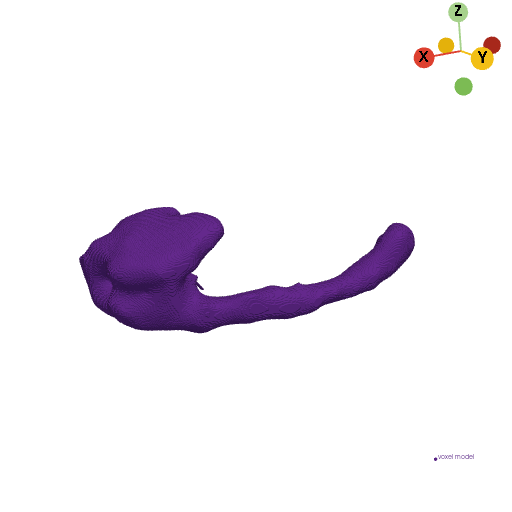

In [6]:
st.pl.three_d_plot(
    model=voxel_model,
    key="tissue",
    model_style="surface",
    jupyter="static",
    cpo=cpo,
    window_size=(512, 512),
)

In [7]:
st.tdr.pc_KDE(pc=pc_model, bandwidth=5, key_added="cells_kde", colormap="Purples", inplace=True)
voxel_model = st.tdr.interpolate_model(model=voxel_model, source=pc_model, N=5, where="point_data")

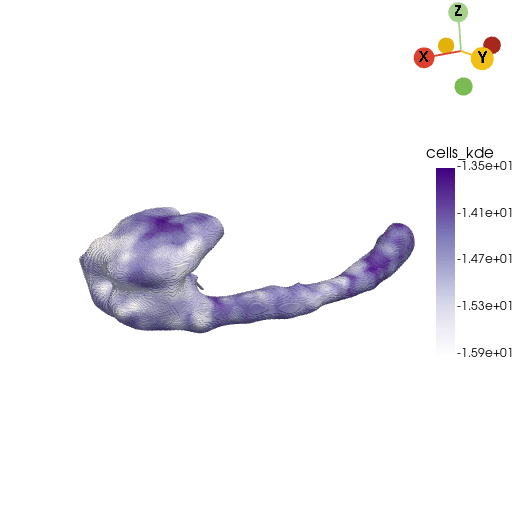

In [8]:
st.pl.three_d_plot(
    model=voxel_model,
    key="cells_kde",
    colormap="Purples",
    model_style="surface",
    jupyter="static",
    cpo=cpo,
    window_size=(512, 512),
)

### Slice the voxel model

In [9]:
slices_x = st.tdr.three_d_slice(model=voxel_model, axis="x", n_slices=15, method="axis")
slices_y = st.tdr.three_d_slice(model=voxel_model, axis="y", n_slices=15, method="axis")
slices_z = st.tdr.three_d_slice(model=voxel_model, axis="z", n_slices=15, method="axis")

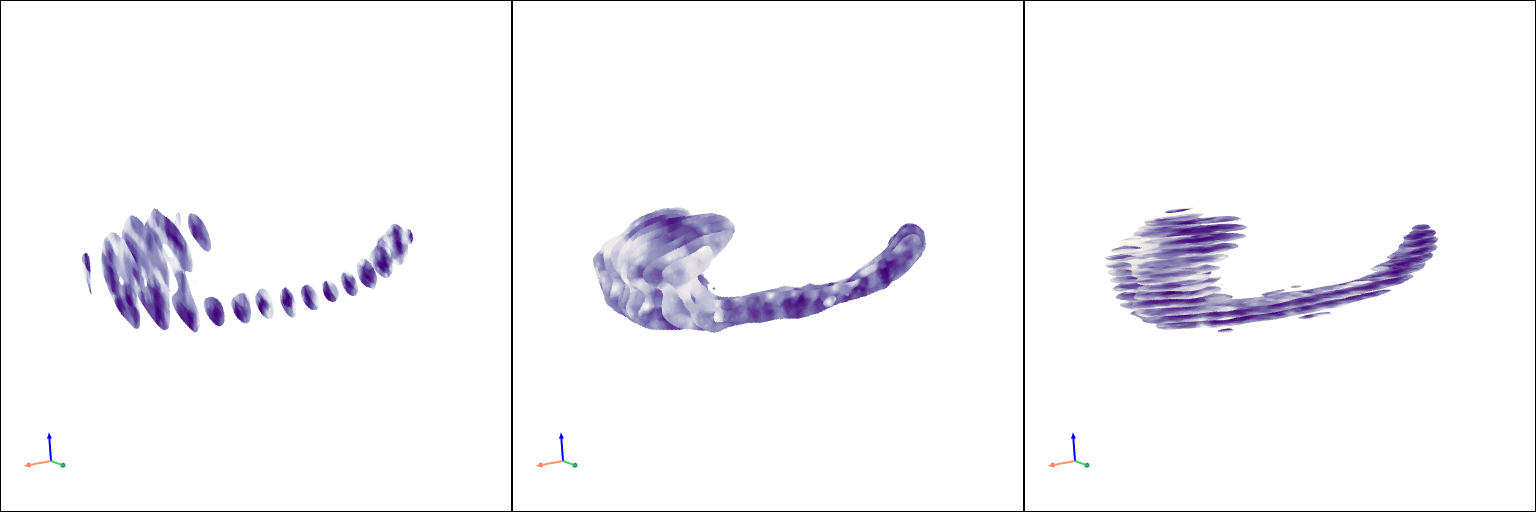

In [15]:
st.pl.three_d_multi_plot(
    model=st.tdr.collect_models([slices_x, slices_y, slices_z]),
    key="cells_kde",
    model_style="surface",
    opacity=1,
    colormap="Purples",
    cpo=[cpo, cpo, cpo],
    ambient=[0.6, 0.3, 0.3],
    shape=(1, 3),
    window_size=(512 * 3, 512),
    jupyter="static",
    show_legend=False,
)

## Calculation of volume, surface area, length, etc.

The coordinates in anndata need a unified unit, such as all coordinates are in microns

In [11]:
um_pc_model, um_mesh_model = pc_model.copy(), mesh_model.copy()

um_pc_model.points = um_pc_model.points / 1000
um_mesh_model.points = um_mesh_model.points / 1000
um_pc_model.points, um_mesh_model.points

(pyvista_ndarray([[ 0.1112383 ,  0.0012526 ,  0.06008248],
                  [ 0.11060692,  0.00497256,  0.05899937],
                  [ 0.10318246,  0.00295338,  0.06027018],
                  ...,
                  [ 0.01069293,  0.05425924, -0.06484415],
                  [ 0.00817535,  0.04934055, -0.06311726],
                  [ 0.00505901,  0.04185745, -0.0605528 ]]),
 pyvista_ndarray([[-0.12004792,  0.03845295, -0.02801299],
                  [-0.11828175,  0.04096001, -0.0273967 ],
                  [-0.12129718,  0.04082316, -0.02625694],
                  ...,
                  [-0.0512333 ,  0.0469347 , -0.0409554 ],
                  [-0.18088684,  0.0528623 , -0.04106622],
                  [-0.21218341,  0.01145639,  0.00956036]]))

In [12]:
morph = st.tdr.model_morphology(model=um_mesh_model, pc=um_pc_model)
morph

|-----> Length (x) of model: 0.45523;
|-----> Width (y) of model: 0.1914;
|-----> Height (z) of model: 0.14527;
|-----> Surface area of model: 0.13207;
|-----> Volume of model: 0.00199;
|-----> Volume / surface area ratio of model: 0.01507.
|-----> Cell density of model: 2173869.34673.


{'Length(x)': 0.45523,
 'Width(y)': 0.1914,
 'Height(z)': 0.14527,
 'Surface_area': 0.13207,
 'Volume': 0.00199,
 'V/SA_ratio': 0.01507,
 'cell_density': 2173869.34673}

## 3D reconstruction of model's backbone and Calculation of model's backbone length

In [13]:
_, backbone, backbone_length = st.tdr.changes_along_branch(
    model=pc_model, rd_method="PrinCurve", NumNodes=30, epochs=300, scale_factor=10, inplace=True, color="orangered"
)
backbone.point_data

2022-10-21 22:25:45.836019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 22:25:45.843441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 22:25:45.844045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 22:25:45.846013: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : nodes
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    tree_rgba               float32    (4323, 4)
    tree                    <U4        (4323,)
    nodes                   int64      (4323,)              SCALARS

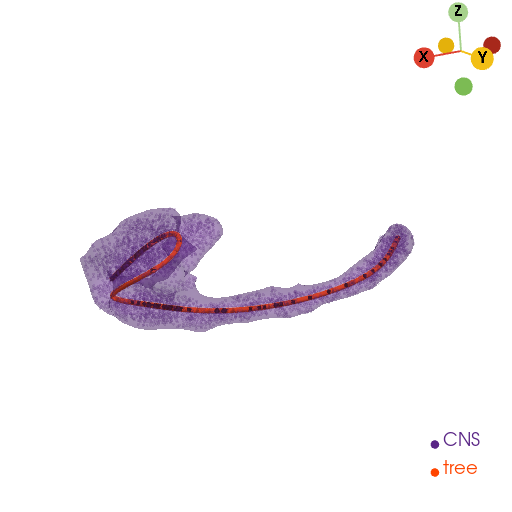

In [14]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([pc_model, mesh_model, backbone]),
    key=["tissue", "tissue", "tree"],
    opacity=[0.2, 0.3, 1],
    model_style=["points", "surface", "wireframe"],
    model_size=[3, 3, 5],
    show_legend=True,
    off_screen=False,
    jupyter="static",
    cpo=cpo,
    window_size=(512, 512),
)